<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds


In [ ]:
!pip install nltk

In [ ]:
!pip install rake-nltk

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
     |████████████████████████████████| 748 kB 38.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from rake_nltk import Rake
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist

import re
import string

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
#tf.get_logger().setLevel('INFO')

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


### Functions For Research Assignment 

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

In [ ]:
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
#     filtered_sentence = [] 
#     for w in word_tokens: 
#         if w not in stop_words: 
#             filtered_sentence.append(w) 

    return filtered_sentence

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
# metho  , stopwords and lemetization


def clean_doc(doc): 
    
    
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
   
    return doc

### Mount Google Drive to Colab Environment

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [ ]:
datafull = pd.read_csv('./MSDS453_Class_CorpusV4.csv')

In [ ]:
counts = datafull["Text"].str.findall(r"(\w+)").explode().value_counts()

In [ ]:
print ("Total number of words= {} : Total number of unque words= {}". format(counts.values.sum(), counts.shape[0]))

Total number of words= 206952 : Total number of unque words= 19353


In [ ]:
#datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

In [ ]:
datafull.columns

Index(['Doc_ID', 'DSI_Title', 'Text', 'Submission File Name', 'Student Name',
       'Genre of Movie', 'Review Type (pos or neg)', 'Movie Title'],
      dtype='object')

In [ ]:
data = datafull[['Text','Review Type (pos or neg)']].copy()

###  Exploratory Analysis AG News Subset

In [ ]:
data['Review Type (pos or neg)'] = data['Review Type (pos or neg)'].astype("category")

In [ ]:
data['Review Type (pos or neg) code'] = data['Review Type (pos or neg)'].cat.codes

In [ ]:

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1

  return count

In [ ]:
wordcount = counter_word(data['Text'])


In [ ]:
wdf = pd.DataFrame(list(wordcount), columns=['Words'])

In [ ]:
counts = data["Text"].str.findall(r"(\w+)").explode().value_counts()

In [ ]:
print ("After Stopword removal and lemmitization: Total number of words= {} : Total number of unque words= {}". format(counts.values.sum(), counts.shape[0]))

After Stopword removal and lemmitization: Total number of words= 206952 : Total number of unque words= 19353


In [ ]:
counts = counts[:100]

In [ ]:
# fig, ax = plt.subplots(figsize=(20,15))
# sns.barplot(x=counts.index, y=counts.values, ax=ax)
# ax.set_ylabel('Number of Occurrences', fontsize=12)
# ax.set_xlabel('Word', fontsize=12)
# ax.xaxis.set_tick_params(rotation=90)

#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
 features, targets = data['Text'], data['Review Type (pos or neg) code']
 
 train_features, test_features, train_targets, test_targets = train_test_split( features, targets , test_size=0.20, random_state=42, shuffle = True,
        stratify=targets)



In [ ]:
# data[["Genre of Movie","Genre of Movie code"]].value_counts()

In [ ]:

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
    #assert (train_split + test_split + val_split) == 1
    
    # Only allows for equal validation and test splits
    #assert val_split == test_split 

    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [ ]:
#train, test,val split

trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Review Type (pos or neg) code']])

In [ ]:
trainds.shape, valds.shape, testds.shape

((199, 2), (25, 2), (25, 2))

In [ ]:
# We convert the data stored in Pandas Data Frame into data stored in TensorFlow Data Set as below:


# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Review Type (pos or neg) code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Review Type (pos or neg) code'].values, tf.int64),

)

#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Review Type (pos or neg) code'].values, tf.int64),

)


**GENERATE THE TRAIN SET BY COMBINING X & Y:
X: the preprocessed & encoded reviews
y: encoded categories)**

In [ ]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)

In [ ]:
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)

In [ ]:
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

**Finalize TensorFlow Data Pipeline by setting necessary parameters for batching, shuffling, and optimizing**




In [ ]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Text                           249 non-null    object  
 1   Review Type (pos or neg)       249 non-null    category
 2   Review Type (pos or neg) code  249 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.7+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
x_train = train_features.to_numpy()

In [ ]:
y_train = train_targets.to_numpy()

In [ ]:
x_test = test_features.to_numpy()

In [ ]:
y_test = test_targets.to_numpy()

In [ ]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)#(train_text_ds_raw)#((train_dataset.map(lambda text, label: text))

In [ ]:
#encoder.get_vocabulary()

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'in', 'is', 'that',
       'it', 'with', 'as', 'for', 'but', 'his', 'this', 'on', 'its', 'by'],
      dtype='<U17')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['refer', 'reeling', 'redundant', 'reduced', 'redolent', 'recycled',
       'recreating', 'records', 'recommend', 'recognizable', 'reckoning',
       'realizing', 'realization', 'reaching', 'raw', 'ravishingly',
       'ratlike', 'ratcheting', 'raped', 'rank'], dtype='<U17')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder('hello how are frozen movie you amazing').numpy()
encoded_example[:]

array([   1,   78,   23,  271,   31,   35, 1879])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
# for n in range(3):
#   print("Original: ", example[n].numpy())
#   print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
#   print()

In [ ]:
len(encoder.get_vocabulary())

5000

In [ ]:
encoder(data['Text'][0])

<tf.Tensor: shape=(551,), dtype=int64, numpy=
array([ 842,   35,   62, 4486,    3,    1,    5, 1771,  271, 3713,   83,
          1,   44,    2, 1257,  362,   12,    1,   20,    1,   12,  559,
         10,  135,   18,   37,    1, 1325,   11,    3,  215,   37,  394,
       3385,    2,  233,    1, 1244,  121,    1,   55, 4772,   19,  389,
         33,  362, 1991, 1491,    4,   18,  284,    6,  769,    3,  819,
        462,    5,  438,    1,  132,    3,    1, 1374,   13,  439,  433,
        439,  271,  281, 2300,  553,    6,   18,    1,  676,    8,   37,
       4116, 2076,    4, 4178,   51,   18, 1776,    9,  198,    1,   82,
         10,  136,    1,  874,   38, 1094,   17,    3,  878,    4, 2165,
         69,    5, 4862,  182,   14,   18,  308,  154,   29,    6,  156,
         39,    3, 3869,    1,   53,   23, 2426,   91,    6, 3785,    4,
          3, 4964,  179,    5, 1150,    6,    2, 1616, 3146,    2,   22,
         93,  416,   11, 1084,   19,  664,    2,  114, 2189,   12,   77,
     

In [ ]:
encoder(data['Text'][0])

<tf.Tensor: shape=(551,), dtype=int64, numpy=
array([ 842,   35,   62, 4486,    3,    1,    5, 1771,  271, 3713,   83,
          1,   44,    2, 1257,  362,   12,    1,   20,    1,   12,  559,
         10,  135,   18,   37,    1, 1325,   11,    3,  215,   37,  394,
       3385,    2,  233,    1, 1244,  121,    1,   55, 4772,   19,  389,
         33,  362, 1991, 1491,    4,   18,  284,    6,  769,    3,  819,
        462,    5,  438,    1,  132,    3,    1, 1374,   13,  439,  433,
        439,  271,  281, 2300,  553,    6,   18,    1,  676,    8,   37,
       4116, 2076,    4, 4178,   51,   18, 1776,    9,  198,    1,   82,
         10,  136,    1,  874,   38, 1094,   17,    3,  878,    4, 2165,
         69,    5, 4862,  182,   14,   18,  308,  154,   29,    6,  156,
         39,    3, 3869,    1,   53,   23, 2426,   91,    6, 3785,    4,
          3, 4964,  179,    5, 1150,    6,    2, 1616, 3146,    2,   22,
         93,  416,   11, 1084,   19,  664,    2,  114, 2189,   12,   77,
     

In [ ]:
for example, label in train_ds.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  #print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'I saw this movie in the theater back in 1999. It had its moments, but not many. To start, the acting is terrible. Keanu Reeves has the emotive ability of a toaster, and Carrie Ann Moss is about as sympathetic as that sexy sidekick babe in a video game. Lawrence Fishburne comes off a bit better, but his dialogue is the most pretentious, ridiculous garbage I\'ve ever heard. I imagine the characters in this film spend about six hours out of every day designing the leather bondage costumes they\'ll wear next time they\'re in the Matrix. For the first half of the movie, it seems to be interested in questioning reality, which, as the title to my review suggests, was already done more topically in previous films. "The Matrix" is astounded by what it perceives as its own brilliance, but for those of us who have thought of its ideas before, there are few surprises. Some people I know were blown away when Neo discovers the truth behind his reality, but I was waiting for something inte

In [ ]:
encoded_example = encoder(example)[:].numpy()
len(encoded_example[1])

1278

In [ ]:
list(train_ds.as_numpy_iterator())

[(array([b'I saw this movie in the theater back in 1999. It had its moments, but not many. To start, the acting is terrible. Keanu Reeves has the emotive ability of a toaster, and Carrie Ann Moss is about as sympathetic as that sexy sidekick babe in a video game. Lawrence Fishburne comes off a bit better, but his dialogue is the most pretentious, ridiculous garbage I\'ve ever heard. I imagine the characters in this film spend about six hours out of every day designing the leather bondage costumes they\'ll wear next time they\'re in the Matrix. For the first half of the movie, it seems to be interested in questioning reality, which, as the title to my review suggests, was already done more topically in previous films. "The Matrix" is astounded by what it perceives as its own brilliance, but for those of us who have thought of its ideas before, there are few surprises. Some people I know were blown away when Neo discovers the truth behind his reality, but I was waiting for something inte

In [ ]:
encoder(x_train[1])

<tf.Tensor: shape=(706,), dtype=int64, numpy=
array([   2, 2825,    5,  126,   94,    8,    9,   45,  415,   11, 2223,
          1,   13,    3, 2585,    1,    1,   51,  121,    1,  493,   66,
         43,   38,    3, 1711,  873,   31,    4,   41, 1800,  454,   38,
        279,   37,   51, 1080,  327,   12,   59,  470,    6,   82,   81,
         80,    4,    9, 1554,    8,  107,    1,   19, 2044,    6,    3,
        493,   45,  167,  161,   67,  644,  132,    3,  171,   12,    3,
          1,   22,   14,  672,  126,  146,   97,   24,   10,   81,    8,
         37, 2879,  126,   51,   66,   43,  149,   38,    4,  212,   18,
        506,   59,    1,   14,   10, 1013, 1059,   43,    9,   12,    3,
        784, 1800,  454,  361,   37,   51,   28, 2405,  863,  497, 2917,
       1623,  218,    1,    8,   26,   30, 1669,  569,  314,   11,  949,
       2984, 2647, 3176, 2350,    1, 1175,  332, 3728, 4889, 3733, 3455,
          1,    1,  645,    4,  501, 2561, 3549, 1167,   30,  508,    9,
     

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [ ]:
num_classes = 1
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes, activation='sigmoid')   # num_classes = 5
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer= 'adam'
              ,loss= tf.keras.losses.BinaryCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trai

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
%%time
history = model.fit(train_ds
                    #x_train, y_train
                    ,epochs = 200
                    ,validation_data = val_ds
                    #,validation_split= 0.2
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]
                    )

Epoch 1/200
66/66 [==============================] - 36s 333ms/step - loss: 0.6947 - accuracy: 0.5051 - val_loss: 0.6945 - val_accuracy: 0.4583
Epoch 2/200
66/66 [==============================] - 18s 278ms/step - loss: 0.6448 - accuracy: 0.7071 - val_loss: 1.3706 - val_accuracy: 0.5417
Epoch 3/200
66/66 [==============================] - 16s 245ms/step - loss: 0.3729 - accuracy: 0.9242 - val_loss: 1.0341 - val_accuracy: 0.5000
Epoch 4/200
66/66 [==============================] - 18s 278ms/step - loss: 0.0309 - accuracy: 0.9949 - val_loss: 1.3634 - val_accuracy: 0.5000
Epoch 5/200
66/66 [==============================] - 17s 258ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.5828 - val_accuracy: 0.5000
Epoch 6/200
66/66 [==============================] - 16s 240ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.7232 - val_accuracy: 0.5417
Epoch 7/200
66/66 [==============================] - 16s 247ms/step - loss: 7.6052e-04 - accuracy: 1.0000 - val_loss: 1.8310 - val_accur

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

8/8 [==============================] - 1s 100ms/step - loss: 2.4794 - accuracy: 0.2917
Test Loss: 2.479448080062866
Test Accuracy: 0.2916666567325592


## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.373,0.924,1.034,0.500
3,0.031,0.995,1.363,0.500
4,0.003,1.000,1.583,0.500
5,0.001,1.000,1.723,0.542
6,0.001,1.000,1.831,0.542
7,0.001,1.000,1.920,0.542
8,0.000,1.000,1.996,0.542
9,0.000,1.000,2.063,0.542
10,0.000,1.000,2.124,0.542
11,0.000,1.000,2.179,0.542


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

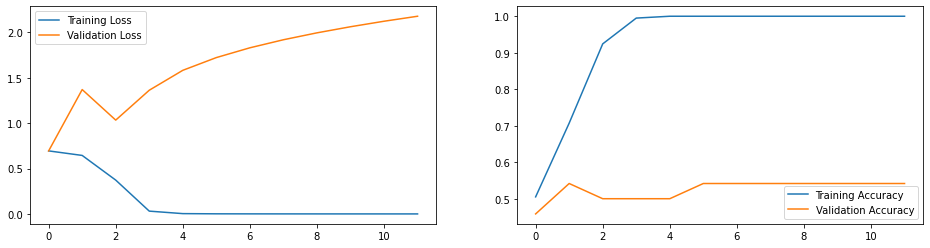

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
preds = model.predict(test_ds)

In [ ]:
y_pred = np.argmax(preds, axis=1)

In [ ]:
y = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
CLASSES_LIST = ['Negative','Postive']

In [ ]:
confusion_matrix(y, y_pred)

array([[ 7,  0],
       [17,  0]])

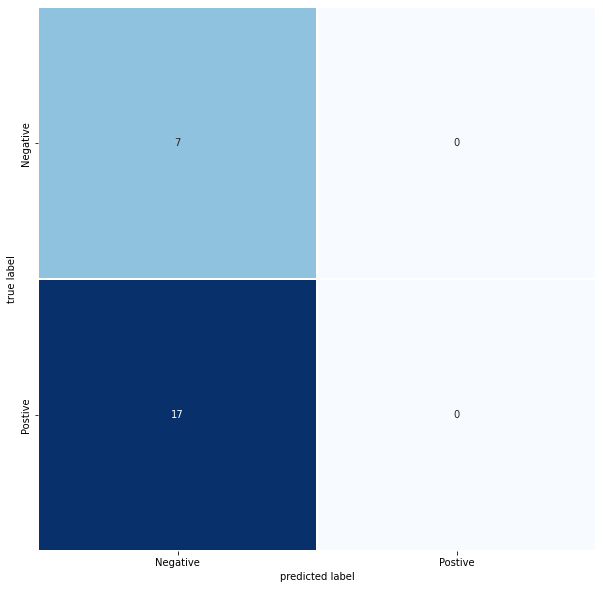

In [ ]:
plot_confusion_matrix_labeled(y,y_pred, CLASSES_LIST=CLASSES_LIST)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
# df = pd.DataFrame(preds[0:15]
#                   ,columns = ['Action','Comedy','Horror','Sci Fi','Drama']).T
# df.style.format("{:.2%}").background_gradient(cmap=cm)

## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trai

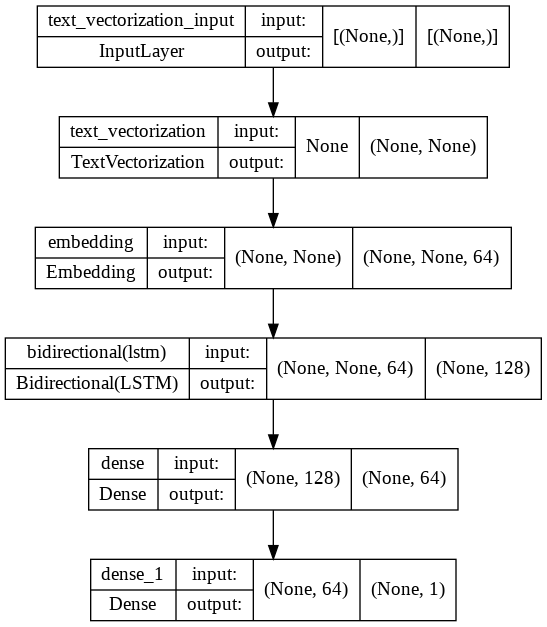

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3))
                              ,tf.keras.layers.Dense(64, activation='relu')
                             
                              ,tf.keras.layers.Dense(num_classes,activation='sigmoid')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
opt = SGD(lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:

model2.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.BinaryCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history2 = model2.fit(train_ds
                    ,epochs=200
                    ,validation_data=val_ds
                    ,validation_steps=3
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]
                    )

Epoch 1/200
66/66 [==============================] - 61s 614ms/step - loss: 0.6943 - accuracy: 0.5051 - val_loss: 0.6936 - val_accuracy: 0.4444
Epoch 2/200
66/66 [==============================] - 30s 451ms/step - loss: 0.6634 - accuracy: 0.6263 - val_loss: 0.8700 - val_accuracy: 0.3333
Epoch 3/200
66/66 [==============================] - 29s 433ms/step - loss: 0.1929 - accuracy: 0.9495 - val_loss: 1.4024 - val_accuracy: 0.3333
Epoch 4/200
66/66 [==============================] - 32s 492ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.6036 - val_accuracy: 0.4444
Epoch 5/200
66/66 [==============================] - 29s 434ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.6767 - val_accuracy: 0.4444
Epoch 6/200
66/66 [==============================] - 28s 418ms/step - loss: 7.4451e-04 - accuracy: 1.0000 - val_loss: 1.6550 - val_accuracy: 0.4444
Epoch 7/200
66/66 [==============================] - 27s 403ms/step - loss: 4.6353e-04 - accuracy: 1.0000 - val_loss: 1.6741 - val_a

In [ ]:
test_loss, test_acc = model2.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

8/8 [==============================] - 1s 166ms/step - loss: 2.1273 - accuracy: 0.4167
Test Loss: 2.1272523403167725
Test Accuracy: 0.4166666567325592


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
6,0.0,1.0,1.674,0.444
7,0.0,1.0,1.710,0.444
8,0.0,1.0,1.731,0.444
9,0.0,1.0,1.751,0.444
10,0.0,1.0,1.772,0.444


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

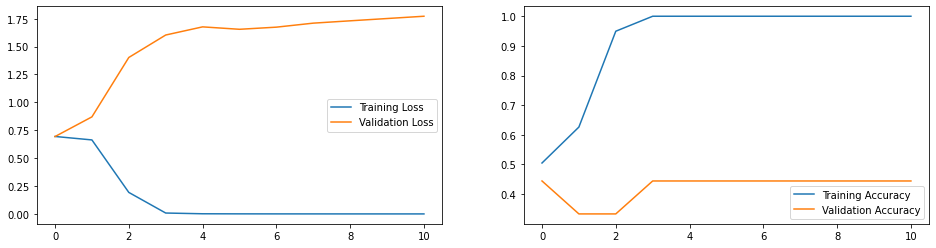

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds2 = model2.predict(test_ds)

In [ ]:
y_pred2 = np.argmax(preds2, axis=1)

In [ ]:
y2 = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
CLASSES_LIST = ['Negative','Positive']

In [ ]:
confusion_matrix(y2, y_pred2)

array([[ 7,  0],
       [17,  0]])

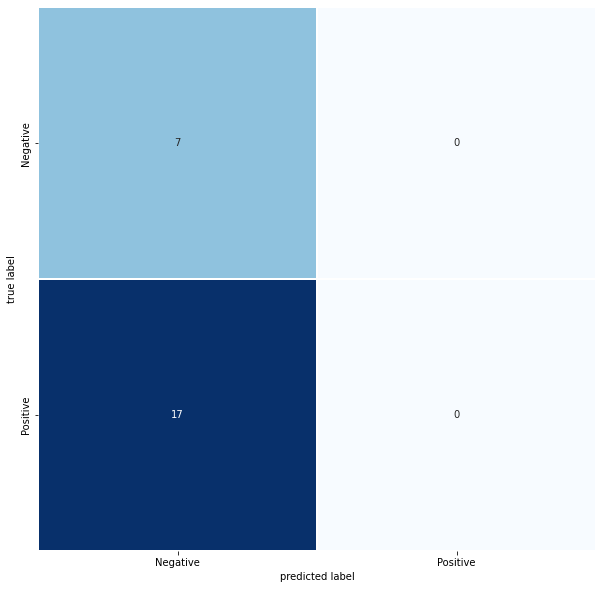

In [ ]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
# df2 = pd.DataFrame(preds[0:15]
#                   ,columns = ['Positive','Negative']).T
# df2.style.format("{:.2%}").background_gradient(cmap=cm)

#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

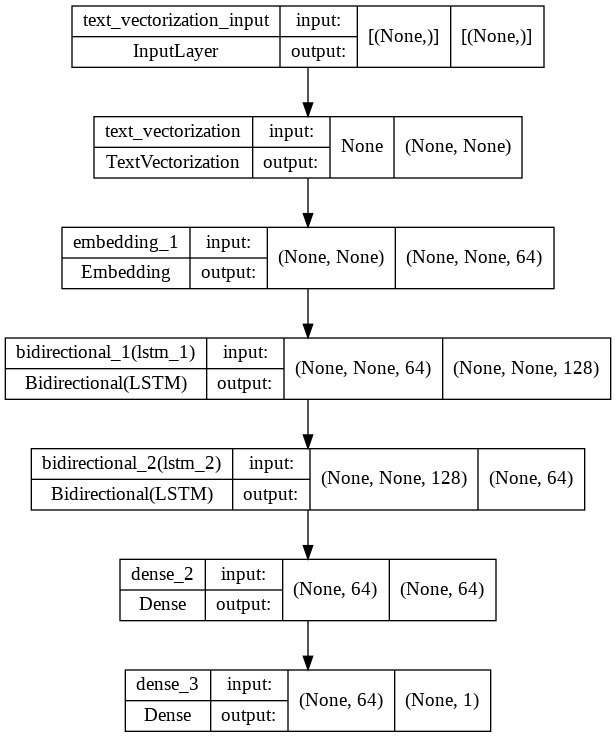

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


# **singel direction**

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [ ]:

num_classes = 1
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.LSTM(64, return_sequences=False)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='sigmoid')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.BinaryCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model

In [ ]:
%%time
history3 = model3.fit(train_ds
                    ,epochs = 200
                    ,validation_data=val_ds
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]
                    )

Epoch 1/200
66/66 [==============================] - 15s 146ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6925 - val_accuracy: 0.5833
Epoch 2/200
66/66 [==============================] - 8s 120ms/step - loss: 0.6917 - accuracy: 0.6162 - val_loss: 0.6924 - val_accuracy: 0.5417
Epoch 3/200
66/66 [==============================] - 8s 124ms/step - loss: 0.6900 - accuracy: 0.6364 - val_loss: 0.6924 - val_accuracy: 0.5417
Epoch 4/200
66/66 [==============================] - 10s 149ms/step - loss: 0.6876 - accuracy: 0.6616 - val_loss: 0.6924 - val_accuracy: 0.5417
Epoch 5/200
66/66 [==============================] - 10s 151ms/step - loss: 0.6829 - accuracy: 0.7576 - val_loss: 0.6921 - val_accuracy: 0.5417
Epoch 6/200
66/66 [==============================] - 10s 146ms/step - loss: 0.6690 - accuracy: 0.8687 - val_loss: 0.6917 - val_accuracy: 0.6250
Epoch 7/200
66/66 [==============================] - 10s 147ms/step - loss: 0.6232 - accuracy: 0.8687 - val_loss: 0.6952 - val_accuracy: 0

In [ ]:
test_loss, test_acc = model3.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

8/8 [==============================] - 1s 64ms/step - loss: 1.1323 - accuracy: 0.5000
Test Loss: 1.1322916746139526
Test Accuracy: 0.5


## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history3_df=pd.DataFrame(history_dict3)
history3_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
6,0.623,0.869,0.695,0.500
7,0.526,0.944,0.695,0.542
8,0.392,0.975,0.690,0.500
9,0.220,0.975,0.773,0.625
10,0.225,0.934,0.927,0.542
11,0.348,0.919,0.871,0.375
12,0.245,0.980,0.944,0.375
13,0.164,0.990,1.082,0.333
14,0.101,0.995,1.252,0.292
15,0.060,1.000,1.424,0.417


In [ ]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

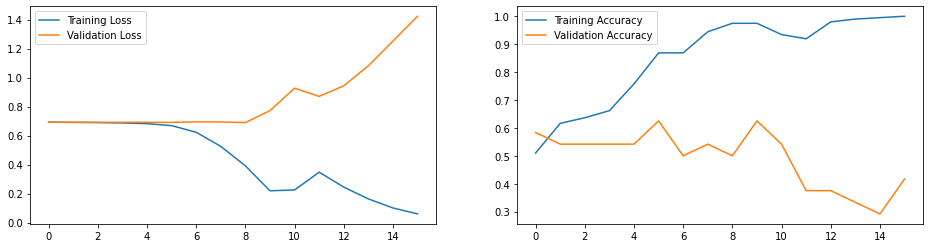

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          320000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 357,249
Trainable params: 357,249
Non-trainable params: 0
________________________________________________

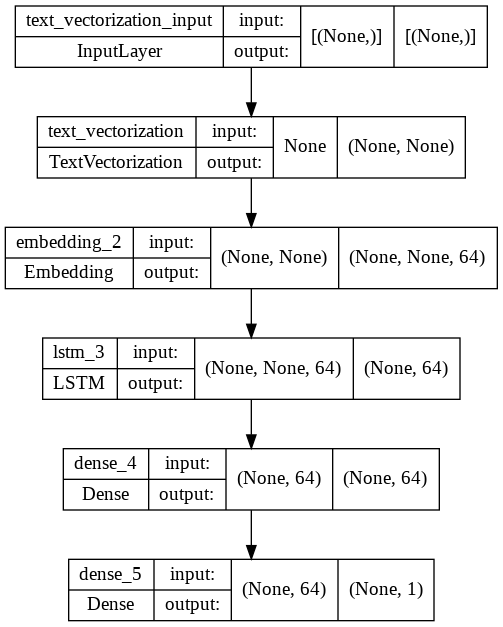

In [ ]:
keras.utils.plot_model(model3, "UniDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
